ロボット制御プログラミング
障害物を回避しながらゴールを目指す動的制御プログラミング法

ライブラリのインポート

In [132]:
import matplotlib
matplotlib.use('nbagg')
import matplotlib.animation as anm
import matplotlib.pyplot as plt
import math
import matplotlib.patches as patches
import numpy as np
from scipy.stats import multivariate_normal
import random 
import copy

画面に表示する世界の状態を表すクラス

In [133]:
class World:
    def __init__(self, time_span, time_interval, debug=True):
        self.objects = []  
        self.debug = debug
        self.time_span = time_span  
        self.time_interval = time_interval
        self.robots = []
        self.goals = []
        
    #要素を追加する関数
    def append(self,obj):  
        self.objects.append(obj)
        #ロボットとゴールは、別に認識
        if isinstance(obj, Robot): self.robots.append(obj)
        if isinstance(obj, Goal): self.goals.append(obj)
    
    #描画関数
    def draw(self):
        #描画設定
        fig = plt.figure(figsize=(6,6))
        ax = fig.add_subplot(111)
        ax.set_aspect('equal')             
        ax.set_xlim(-5,10)                  
        ax.set_ylim(-5,10) 
        ax.set_xlabel("X",fontsize=10)                 
        ax.set_ylabel("Y",fontsize=10)                 
        
        #描画要素のリスト
        elems = []
        
        #描画実行（デバッグ用に分岐あり）
        if self.debug:        
            for i in range(int(self.time_span/self.time_interval)): self.one_step(i, elems, ax)
        else:
            self.ani = anm.FuncAnimation(fig, self.one_step, fargs=(elems, ax),
                                     frames=int(self.time_span/self.time_interval)+1, interval=int(self.time_interval*1000), repeat=False)
            plt.show()
    
    #状態を更新する関数
    def one_step(self, i, elems, ax):
        while elems: elems.pop().remove()
        #時間を進める
        time_str = "t = %.2f[s]" % (self.time_interval*i)
        elems.append(ax.text(-4.4, 4.5, time_str, fontsize=10))
        #状態更新
        for obj in self.objects:
            obj.draw(ax, elems)
            if hasattr(obj, "one_step"): obj.one_step(self.time_interval)
        #ゴール判定
        for r in self.robots:
            for g in self.goals:
                    if g.inside(r.pose):
                        r.agent.in_goal = True

ゴールのクラス

In [134]:
class Goal: 
    def __init__(self, x, y, radius=0.3):
        self.pos = np.array([x, y]).T
        self.radius = radius
        self.height = 10
    
    #判定
    def inside(self, pose): 
        return self.radius > math.sqrt( (self.pos[0]-pose[0])**2 + (self.pos[1]-pose[1])**2 )
    
    #描画
    def draw(self, ax, elems):
        x, y = self.pos
        c = ax.scatter(x + 0.2, y + 0.8, s=30, marker=">", label="landmarks", color="red")
        elems.append(c)
        elems += ax.plot([x, x], [y, y + 1], color="black")

ロボット本体のクラス

In [135]:
class Robot:   
    def __init__(self, pose, agent=None, color="black"):   
        self.pose = pose
        self.r = 0.2  
        self.color = color 
        self.agent = agent
        self.poses = [pose]
    
    #描画
    def draw(self, ax, elems): 
        x, y, theta = self.pose  
        xn = x + self.r * math.cos(theta)  
        yn = y + self.r * math.sin(theta)  
        elems += ax.plot([x,xn], [y,yn], color=self.color)
        c = patches.Circle(xy=(x, y), radius=self.r, fill=False, color=self.color) 
        elems.append(ax.add_patch(c))
        self.poses.append(self.pose)
        elems += ax.plot([e[0] for e in self.poses], [e[1] for e in self.poses], linewidth=0.5, color="black")
        if self.agent and hasattr(self.agent, "draw"):                       
            self.agent.draw(ax, elems)
    
    #本体を進める関数
    @classmethod           
    def state_transition(cls, nu, omega, time, pose):
        t0 = pose[2]
        #回転速度の違いで分岐
        if math.fabs(omega) < 1e-10:
            return pose + np.array( [nu*math.cos(t0), 
                                     nu*math.sin(t0),
                                     omega ] ) * time
        else:
            return pose + np.array( [nu/omega*(math.sin(t0 + omega*time) - math.sin(t0)), 
                                     nu/omega*(-math.cos(t0 + omega*time) + math.cos(t0)),
                                     omega*time ] )
    #状態更新する関数
    def one_step(self, time_interval):
        if not self.agent: return        
        nu, omega = self.agent.decision()
        self.pose = self.state_transition(nu, omega, time_interval, self.pose)
        self.agent.pose = self.pose 

群を成す粒子のクラス

In [136]:
class Particle: 
    def __init__(self, init_pose, weight):
        self.pose = init_pose
        self.weight = weight
        self.per = init_pose
        self.delta = np.array([0, 0, 0]).T
    
    #動作させる関数
    def motion_update(self, time, glob, w = 0.1, b = 0.01, c = 1, ramda = 2):
        self.delta = (w * self.delta) + (b * ramda * np.random.rand() * (self.per - self.pose)) +  (c * ramda * np.random.rand() * (glob - self.pose))
        self.delta = self.delta / np.abs(self.delta)
        self.delta[np.isnan(self.delta)] = 0
        self.pose = self.pose + self.delta * time  
            

群全体のクラス

In [137]:
class group:  
    def __init__(self, envmap, goal, sensor = None):
        self.particles = []
        self.map = envmap
        self.goal = goal
        self.sensor = sensor
        self.obstacle = 10
    
    #粒子を追加する関数
    def append_particles(self, init_pose, num):
        for i in range(num):
            #初期値設定
            pose = init_pose + np.array([np.random.randint(-2,2), np.random.randint(-2,2), 0]).T
            diff = pose[:2] - self.goal.pos
            weight = self.goal.height - np.hypot(*diff)
            observe = self.sensor.data(pose)
            if observe:
                for lm in observe:
                    weight = weight - (self.obstacle - lm[0][0])
            self.particles.append(Particle(pose, weight))
        #最良の個体を決定する
        self.set_best()
        
    #最良の個体を設定する関数
    def set_best(self):
        i = np.argmax([p.weight for p in self.particles])
        self.best = self.particles[i]
        self.pos = self.best.pose 
    
    #各粒子を移動させる関数
    def motion_update(self, time): 
        for p in self.particles: p.motion_update(time, self.pos)
    
    #各粒子の評価値更新
    def observation_update(self, observation, robo_pos): 
        for p in self.particles:
            #ゴールとの距離を評価とする
            diff = p.pose[:2] - self.goal.pos
            weight = self.goal.height - np.hypot(*diff)
            #障害物と近いほど減点
            observe = self.sensor.data(p.pose)
            if observe:
                for lm in observe:
                    weight = weight - (self.obstacle - lm[0][0])
            if p.weight < weight:
                p.per = p.pose
            #移動コストを追加
            cost = p.pose[:2] - robo_pos[:2]
            p.weight = weight - np.hypot(*cost)
        self.set_best()
        
    #描画
    def draw(self, ax, elems):  
        c = ax.scatter(self.best.pose[0], self.best.pose[1], s=30, marker=".", color="blue")
        elems.append(c)

ロボットの目標を定める関数

In [138]:
class Agent(): 
    def __init__(self, pose, time_interval, estimator, goal):
        self.nu = 0
        self.omega = 0
        self.pose = pose
        self.estimator = estimator
        self.time_interval = time_interval
        
        self.prev_nu = 0
        self.prev_omega = 0
        self.in_goal = False
        self.goal = goal
    
    #目標に向かう関数
    @classmethod   
    def policy(cls, pose, goal):
        x, y, theta = pose
        dx, dy = goal.pos[0] - x, goal.pos[1] - y
        direction = int((math.atan2(dy, dx) - theta)*180/math.pi)   #ゴールの方角（degreeに直す）
        direction = (direction + 360*1000 + 180)%360 - 180      #方角を-180〜180[deg]に正規化（適当。ロボットが-1000回転すると破綻）
        
        if (direction < 20) and (direction > -20): nu, omega = 2.0, 0.0
        elif direction > 90:  nu, omega = -0.5, 0.0
        elif direction < -90: nu, omega = -0.5, 0.0
        elif direction > 0: nu, omega = 0.0, 2.0
        else: nu, omega = 0.0, -2.0
            
        return nu, omega
    
    #速度決定関数
    def decision(self, observation=None): 
        if self.in_goal:
            return 0.0, 0.0
        #群れを更新する
        self.estimator.motion_update(self.time_interval)
        self.estimator.observation_update(observation, self.pose)
        #目標を定める
        nu, omega = self.policy(self.pose, self.estimator)
        self.prev_nu, self.prev_omega = nu, omega
        
        return nu, omega
   
    #描画
    def draw(self, ax, elems): 
        self.estimator.draw(ax, elems)
        x, y, t = self.estimator.pos 

障害物のクラス

In [139]:
class Obstacle:
    def __init__(self, x, y):
        self.pos = np.array([x, y]).T
        self.id = None
    
    #移動関数
    def motion_update(self, time_interval):
        self.pos = self.pos + np.array( [np.random.randn(),np.random.randn()] ) * time_interval
        
    #描画
    def draw(self, ax, elems):
        c = ax.scatter(self.pos[0], self.pos[1], s=30, marker=".", label="landmarks", color="orange")
        elems.append(c)

障害物を管理するクラス

In [140]:
class Map:
    def __init__(self):       # 空のランドマークのリストを準備
        self.obstacles = []
        
    def append_obstacle(self, obstacle):       # ランドマークを追加
        obstacle.id = len(self.obstacles)           # 追加するランドマークにIDを与える
        self.obstacles.append(obstacle)
        
    def one_step(self, time_interval):
        for lm in self.obstacles: lm.motion_update(time_interval)

    def draw(self, ax, elems):                 # 描画
        for lm in self.obstacles: lm.draw(ax, elems)

センサーのクラス

In [141]:
class Camera:
    def __init__(self, env_map, \
                 distance_range=(0, 1.0),
                 direction_range=(-math.pi, math.pi)):
        self.map = env_map
        self.lastdata = []
        
        self.distance_range = distance_range
        self.direction_range = direction_range
    
    #見える判定の関数
    def visible(self, polarpos):  
        if polarpos is None:
            return False
        
        return self.distance_range[0] <= polarpos[0] <= self.distance_range[1] \
                and self.direction_range[0] <= polarpos[1] <= self.direction_range[1]
    
    #見えたデータを作成する関数
    def data(self, cam_pose):
        observed = []
        for lm in self.map.obstacles:
            z = self.observation_function(cam_pose, lm.pos)
            if self.visible(z):               # 条件を追加
                observed.append((z, lm.id))   # インデント
            
        self.lastdata = observed 
        return observed
    
    #距離と方向を算出する関数
    @classmethod
    def observation_function(cls, cam_pose, obj_pos):
        diff = obj_pos - cam_pose[0:2]
        phi = math.atan2(diff[1], diff[0]) - cam_pose[2]
        while phi >= np.pi: phi -= 2*np.pi
        while phi < -np.pi: phi += 2*np.pi
        return np.array( [np.hypot(*diff), phi ] ).T
    
    #描画
    def draw(self, ax, elems, cam_pose): 
        for lm in self.lastdata:
            x, y, theta = cam_pose
            distance, direction = lm[0][0], lm[0][1]
            lx = x + distance * math.cos(direction + theta)
            ly = y + distance * math.sin(direction + theta)
            elems += ax.plot([x,lx], [y,ly], color="pink")

<IPython.core.display.Javascript object>


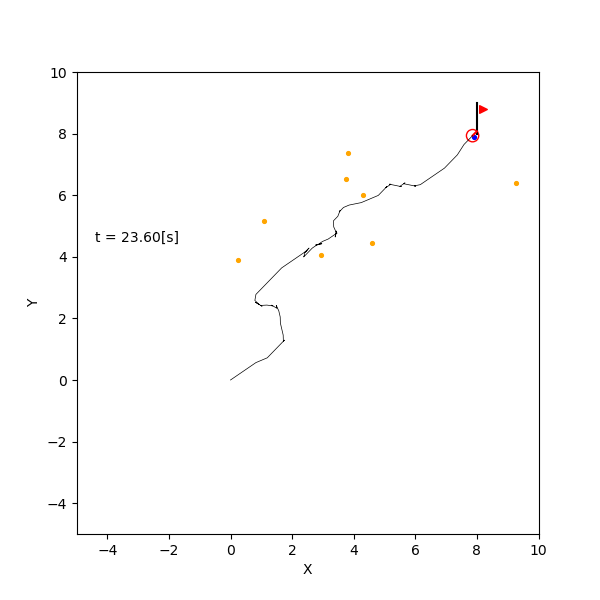

In [142]:
if __name__ == '__main__':   ###name_indent
    
    time_interval = 0.1
    world = World(30, time_interval, debug=False) 

    ### 地図を生成して3つランドマークを追加 ###
    m = Map()
    obs_num = 9
    a = np.linspace(1,10,obs_num)
    for i in range(obs_num):
        x_posi = a[i] + np.random.randn()
        y_posi = a[i] + np.random.randn()
        m.append_obstacle(Obstacle(x_posi,y_posi))
    world.append(m)      
    
    ##ゴールの追加##
    goal = Goal(8,8)  #goalを変数に
    world.append(goal)

    ### ロボットを作る ###
    initial_pose = np.array([0, 0, 0]).T
    estimator = group(m, goal, sensor = Camera(m)) #地図mを渡す
    estimator.append_particles(initial_pose, 100)
    a = Agent(initial_pose, time_interval, estimator, goal)
    r = Robot(initial_pose, agent=a, color="red")
    world.append(r)

    ### アニメーション実行 ###
    world.draw()